In [409]:
import pandas as pd
import numpy as np
from numpy import array

edgar_dataset = '/home/cj/Bureau/Master2/bdp/database/edgar_database_2018.xls'

# Data sheets of the emissions of CO2 by sectors depending on the country
co2_sector_country = 'fossil_CO2_by_sector_and_countr'
data_co2_sector_country = pd.read_excel(open(edgar_dataset, 'rb'),
                                  sheet_name = co2_sector_country)

# 1 : Data set #

## We consider Belgium CO2 emissions by sectors. ##

In [410]:
data_co2_sector_country.head()

,Sector,country_name,1970,1971,1972,1973,1974,1975,1976,1977,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Power Industry,Afghanistan,0.056962,0.056962,0.116895,0.174969,0.206875,0.210758,0.241009,0.375716,...,1.588591,2.017081,2.116617,2.100720,3.233659,3.414392,3.241768,3.241768,3.322330,3.419763
1,Power Industry,Albania,0.600624,0.600624,0.616104,0.613008,0.606816,0.532512,0.535608,0.510840,...,0.006192,0.015480,0.030960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Power Industry,Algeria,1.645869,1.645869,1.550235,1.221972,1.465168,2.111895,2.530895,2.819267,...,24.666333,25.086252,28.120880,30.929377,30.094453,32.629870,36.774115,36.177305,36.416426,39.915370
3,Power Industry,Angola,0.137546,0.137546,0.159283,0.168752,0.371864,0.352957,0.346584,0.346584,...,2.226396,2.369069,2.229655,1.843470,2.325888,3.441893,3.775559,3.974273,3.967023,4.066821
4,Power Industry,Anguilla,0.000430,0.000430,0.000436,0.000438,0.000447,0.000480,0.000521,0.000449,...,0.000778,0.000790,0.000910,0.000910,0.000978,0.000976,0.000980,0.000990,0.000985,0.001011


In [411]:
dataset = data_co2_sector_country.loc[data_co2_sector_country['country_name'] == 'Belgium']
sector_names = dataset['Sector'].to_list()
del dataset['country_name']
del dataset['Sector']

dataset = dataset.transpose()
dataset.columns = sector_names

# A column representing the sum of all sectors is added to the dataset.
Total = np.zeros(len(dataset))
Total = pd.Series(Total)
Total = dataset.iloc[:,1] + dataset.iloc[:,2]
for i in range(5) : Total = Total + dataset.iloc[:,i]
    
dataset['Total'] = Total

dataset = dataset.astype('float32')
dataset.head()

,Power Industry,Buildings,Transport,Other industrial combustion,Other sectors,Total
1970,27.047808,35.884159,11.413301,50.741562,15.272869,187.657166
1971,29.284933,33.066238,11.830670,43.790886,12.166234,175.035873
1972,32.564274,36.309933,12.646909,46.441601,13.717597,190.637161
1973,35.604969,36.831837,12.949210,47.686749,13.476537,196.330338
1974,38.689392,33.134407,12.561368,46.169109,14.476633,190.726685


In [412]:
# save dataset
dataset.to_csv('belgium_consumption_sector.csv')

# 2. Problem framing #
Given the consumption of CO2 of different sectors, what is the expected annual CO2 consumption fot the 12 next years ?
This requires that a predictive model forcasts the total active power for each year over the next 12 years. This is called *multivariate multi-step time series Forcasting model.*

Why 12 years ? Because this dataset stops in 2018 and we are asked to predict the emissions of CO2 in 2030.

# 3. Resolution #

In [413]:
from pandas import read_csv
dataset = read_csv('/home/cj/Documents/belgium_consumption_sector.csv',
                   infer_datetime_format=True, index_col=['Unnamed: 0'])

## Split the dataset ## 

In [414]:
def split_dataset(X, m): # m is the size of the validation set & X the dataset.
    n_train = len(X) - m
    train = X[0:n_train]
    test = X[n_train:len(X)]
    return train, test

## Convert the multivariate matrix into an univariate matrix  ##

In [442]:
# Convert the multivariate matrix into an univariate matrix.
# We want to forecast one row of the dataset.
def to_series(data, var):
    # extract the wanted variable
    series = [row[var] for row in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

## Pipeline ##

In [416]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

## One-step forecast ##

In [417]:
def forecast(model, input_x, n_input):
    yhat_sequence = list()
    input_data = [x for x in input_x]
    
    # prepare the input data
    X = array(input_data[-n_input:]).reshape(1, n_input)
    # make a ONE-STEP forecast
    yhat = model.predict(X)[0]

    return yhat

## Creation of the supervided dataset ##

In [418]:
# converts the window into train and test sets
def train_test_datasets(window, n_input, var):
    
    # convert the window of data into an univariate serie
    data = to_series(window, var) 
    
    X, y = list(), list()
    
    ix_start = 0
    # step over the entire window one time step at a time
    
    for i in range(len(data)):
        # define the end of the input sequence
        ix_end = ix_start + n_input
        # ensure we have enough data for this instance
        if ix_end < len(data):
            X.append(data[ix_start:ix_end])
            y.append(data[ix_end])
        # move along one time step
        ix_start += 1
    
    train_x_y = []; train_x_y.append(array(X)); train_x_y.append(array(y))
    return train_x_y

## Trainining & prediction ##

In [419]:
def model_prediction(model, window, n_input, var):
    # prepare data
    train_x_y = train_test_datasets(window, n_input, var)
    train_x = train_x_y[0]
    train_y = train_x_y[1]
    # make pipeline
    pipeline = make_pipeline(model)
    # fit the model
    pipeline.fit(train_x, train_y)
    
    last_year = train_y[len(train_y)-1] # last value of the training set
    # this value is added to the 4 values of train_x in order to form the input
    input_row = np.append(train_x[len(train_x)-1, 1:n_input], last_year)   
    
    # predict the next year knowing the n_input last years
    yhat_sequence = forecast(pipeline, input_row, n_input)
    return yhat_sequence

## Evaluation of each model ##

In [420]:
def evaluate_model(model, train, test, n_input, var): # FOR ONE VARIABLE AT THE TIME.
    
    window = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)): # 12 times, you predict 1 by 1
        # predict the year
        yhat_sequence = model_prediction(model, window, n_input, var)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to window for predicting the next week
        window.append(test[i, :]) # no need to give all the lines unless you predict all the variable at the same time which will be done
    predictions = array(predictions)

    return predictions

## How well a model performed ? ##

In [421]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

def evalutation_forecast(real, pred):
    pred = to_pd_series(pred)
    real = to_pd_series(real)
    #diff = list()
    #for i in range(len(real)): diff.append(abs(real[i]-pred[i]))
    
    #mse = mean_squared_error(real, pred)
    #rmse = sqrt(mse)
    mae = mean_absolute_error(real, pred)
  
    return mae

In [422]:
def sort_models(eval_model):
    models_sorted = sorted(eval_model.items(), key=lambda x: x[1], reverse=False)
    return models_sorted

In [423]:
def model_sorted(list_eval_model):

    for i, sector in name_sector.items():
        print_evaluation(sector, sort_models(list_eval_model[i]))
        print('\n')

In [424]:
def print_evaluation(sector, models_sorted):
    print(sector)
    for i in range(len(models_sorted)) :
        print('{}. {} : {}'.format(i+1, models_sorted[i][0], models_sorted[i][1]))

## Plot ##

In [425]:
def to_pd_series(data):
    data = [x for x in data]
    data = array(data).flatten()
    data = pd.Series(data)
    
    return data

In [426]:
def plotly_plot_model(fig, pred, name):
    fig.add_trace(go.Scatter(
                x=years,
                y=to_pd_series(pred),
                name=name,
                opacity=0.8))
    return fig

In [427]:
from matplotlib import pyplot

def matplotlib_plot_model(predictions, var, test, name_sector):
    
    name = ['lr', 'lasso', 'ridge', 'sgd', 'pa', 'en', 'hubert', 'lars', 'llars', 'ranscac']
    years = pd.Series(dataset.index.values[-12:])
    
    for i in range(len(predictions)):
        pyplot.plot(years, predictions[i], marker='o', label=name[i])
        
    pyplot.plot(years, to_pd_series(test[:,var]), marker='o', label='real', color='black')
    
    pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    pyplot.title('Carbon dyoxide emissions by '+ name_sector[var])
    pyplot.xlabel('years')
    pyplot.ylabel('Carbone dioxyde (Mt/yr)')
    pyplot.show()

In [428]:
def plot_function(figures, variables, test, name_sector):
    
    years = pd.Series(dataset.index.values[-12:])

    for var in variables:

        figures[var].add_trace(go.Scatter(
                        x=years,
                        y=to_pd_series(test[:,var]),
                        name='Real',
                        line=go.scatter.Line(color="black"),
                        opacity=1))

        figures[var].update_layout(title_text="Carbon dyoxide emissions by "+ name_sector[var],
                          xaxis={"title":"Years"}, yaxis={"title":"Carbone dioxyde (Mt/yr)"})
        figures[var].show()

## Linear models tested ##

In [429]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

models = dict()
# LINEARS MODELS ONLY
models['lr'] = LinearRegression()
models['lasso'] = Lasso()
models['ridge'] = Ridge()
models['sgd'] = SGDRegressor(max_iter=5000, tol=1e-3)
models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
models['en'] = ElasticNet()
models['huber'] = HuberRegressor()
models['lars'] = Lars()
models['llars'] = LassoLars()
models['ranscac'] = RANSACRegressor()

## Main ##

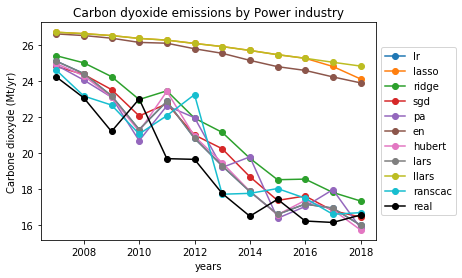

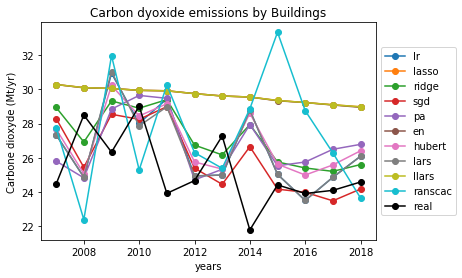

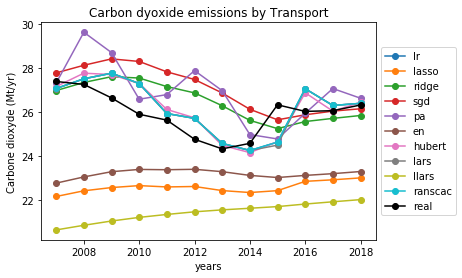

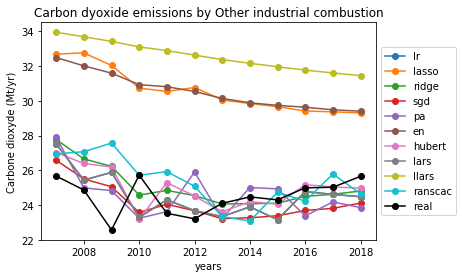

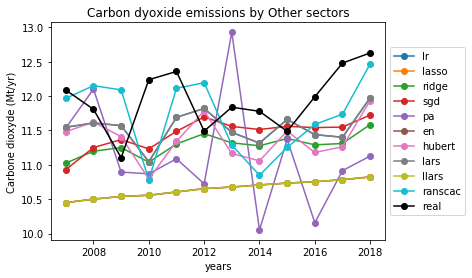

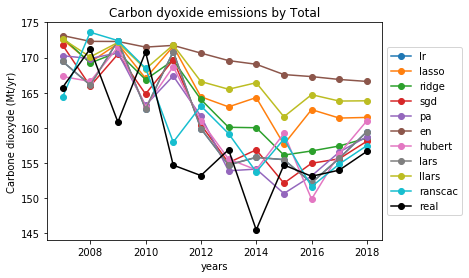

In [430]:
from matplotlib import pyplot
import plotly.graph_objects as go

name_sector = {0:'Power industry', 1:'Buildings', 2:'Transport',
                   3:'Other industrial combustion', 4:'Other sectors', 5:'Total'}

train, test = split_dataset(dataset.values, 12)

n_input = 6
years = pd.Series(dataset.index.values[-12:])

variables = [0, 1, 2, 3, 4, 5]
figures = list()
for i in range(len(variables)): figures.append(go.Figure())
list_eval_model = list()

list_pred = list()

for var in variables:
    eval_model = dict()
    for name, model in models.items():
    
        pred = evaluate_model(model, train, test, n_input, var)
        list_pred.append(pred)
        mae = evalutation_forecast(test[:,var], pred)
    
        eval_model[name] = mae
    
        figures[var] = plotly_plot_model(figures[var], pred, name)
            
    list_eval_model.append(eval_model)
    matplotlib_plot_model(list_pred, var, test, name_sector)
    list_pred = list()

## Best models evaluated with MAE for each sector ##

In [431]:
model_sorted(list_eval_model)

Power industry
1. ranscac : 1.137372789517446
2. lr : 1.3587070924331703
3. lars : 1.358707092433171
4. sgd : 1.370477816245809
5. huber : 1.4446913708339313
6. pa : 1.6900605429906619
7. ridge : 2.0623567815684303
8. en : 6.197874605577567
9. lasso : 6.53938799119253
10. llars : 6.618436754200076


Buildings
1. sgd : 2.0533855995540846
2. ridge : 2.406808962700204
3. pa : 2.446634290659891
4. lars : 2.5165886793370054
5. lr : 2.5344556634171838
6. huber : 2.6428260626005367
7. ranscac : 4.3744277771766535
8. en : 4.394498819073153
9. lasso : 4.400564330633393
10. llars : 4.400564330633393


Transport
1. huber : 0.6589214438724452
2. ranscac : 0.6636593951643581
3. lr : 0.6639135294668236
4. lars : 0.6754837817638689
5. ridge : 1.0117243713603206
6. pa : 1.2903159624707996
7. sgd : 1.2905727967403973
8. en : 2.7458495836805725
9. lasso : 3.3576564835848153
10. llars : 4.508266031729942


Other industrial combustion
1. lars : 1.1418621251076464
2. lr : 1.1418621251076475
3. ridge : 1.14

Comments : 'Other sectors' is very badly predicted using linear predictors. We need to compare total CO2 emissions
with and without this particular sector. The total (sum of all columns is totally wrong !). You can also take the sum of all sectors (with their best predictor).

# PLOT #

In [432]:
plot_function(figures, variables, test, name_sector)

Except for the Power industry, all other sectors are badly predicted as aswell as 'Total'.

# 4. FROM 2019 TO 2030 #

In [444]:
def model_from_2019_to_2030(model, train, n_input, var): # FOR ONE VARIABLE AT THE TIME.
    
    window = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(12): # 12 times, you predict 1 by 1
        # predict the year
        yhat_sequence = model_prediction(model, window, n_input, var)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to window for predicting the next week
        new_year = np.zeros(6)
        new_year[var] = yhat_sequence
        window.append(new_year)
        
    predictions = array(predictions)

    return predictions

In [445]:
def matplotlib_future(predictions, train, var):
    
    name = ['lr', 'lasso', 'ridge', 'sgd', 'pa', 'en', 'hubert', 'lars', 'llars', 'ranscac']
    k = 0
    
    y_values = np.zeros(30)
    for i in range(18): y_values[i] = x1 = train[-18:,var][i]
    for pred in predictions:
        for j in range(12): y_values[i+1+j] = pred[j]
        pyplot.plot(years_30, y_values, marker='o', color='blue')
        pyplot.plot(years_30[18:30], y_values[18:30], marker='o', label=name[k])
        pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        k+=1
            
    pyplot.title('Carbon dyoxide emissions by '+ name_sector[var])
    pyplot.xlabel('years')
    pyplot.ylabel('Carbone dioxyde (Mt/yr)')
    pyplot.show()

In [ ]:
def plotly_plot_model(fig, pred, name, years):
    fig.add_trace(go.Scatter(
                x=years[18:30],
                y=to_pd_series(pred[18:30]),
                name=name,
                opacity=0.8))
    return fig

In [450]:
def plot_function_future(figures, variables, test, name_sector, years): 
    
    fig.add_trace(go.Scatter(
            x=years[18:30],
            y=to_pd_series(pred[18:30]),
            name=name,
            opacity=0.8))
    
    for var in variables:

        figures[var].update_layout(title_text="Carbon dyoxide emissions by "+ name_sector[var],
                          xaxis={"title":"Years"}, yaxis={"title":"Carbone dioxyde (Mt/yr)"})
        figures[var].show()

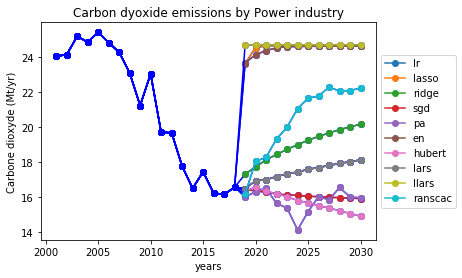

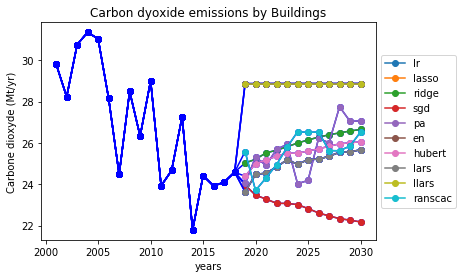

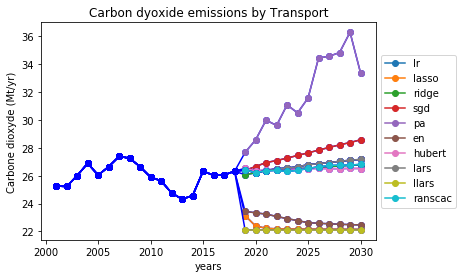

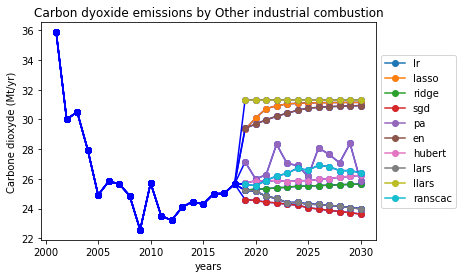

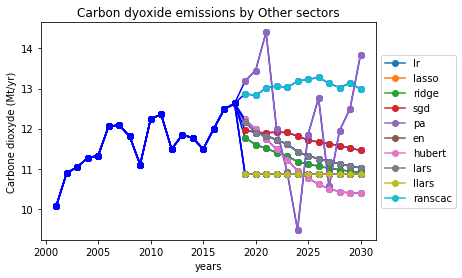

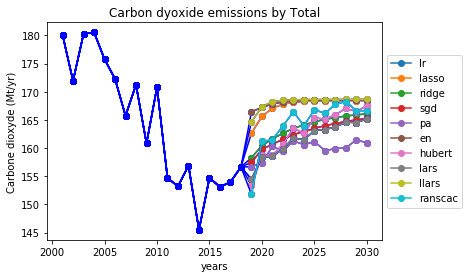

In [448]:
from matplotlib import pyplot
import plotly.graph_objects as go

name_sector = {0:'Power industry', 1:'Buildings', 2:'Transport',
                   3:'Other industrial combustion', 4:'Other sectors', 5:'Total'}

years_30 = np.zeros(30)
for i in range(len(years_30)): years_30[i] = np.int64(2001+i)
years_30 = pd.Series(years_30)

train, test = split_dataset(dataset.values, 0)
n_input = 6

variables = [0, 1, 2, 3, 4, 5]
#variables = [3]
figures_30 = list()
for i in range(len(variables)): figures_30.append(go.Figure())

list_pred = list()

for var in variables:
    for name, model in models.items():
    
        pred = model_from_2019_to_2030(model, train, n_input, var)
        list_pred.append(pred)
    
        #figures_30[var] = plotly_plot_model(figures_30[var], train, pred, name, years_30)
            
    matplotlib_future(list_pred, train, var)
    list_pred = list()

In [ ]:
# look mae at each point

# 5. Autoregressive models #

In [61]:
# Let's compute the number of lags we need for the AR model.
# We use the partial autocorrelation function
# We assume all variable are gaussian in order to use the Pearson's correlation coefficient 
# used in the partial autocorrelation formulae

### Partial autocorrelation function ###

In [62]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 432x288 with 0 Axes>

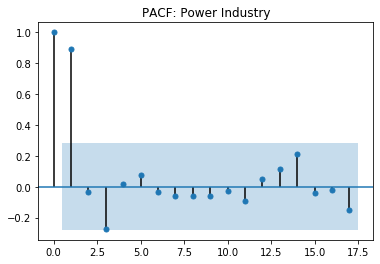

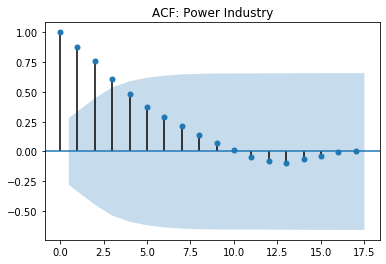

In [63]:
pyplot.figure()
plot_pacf(dataset['Power Industry'], title='PACF: Power Industry')
plot_acf(dataset['Power Industry'], title='ACF: Power Industry')
pyplot.show()

In [64]:
print('For nlags = 0 : {}'.format(pacf(dataset['Power Industry'], nlags=2)[0]))
print('For nlags = 1 : {}'.format(pacf(dataset['Power Industry'], nlags=2)[1]))
print('For nlags = 2 : {}'.format(pacf(dataset['Power Industry'], nlags=2)[2]))
print('For nlags = 3 : {}'.format(pacf(dataset['Power Industry'], nlags=3)[3]))

For nlags = 0 : 1.0
For nlags = 1 : 0.8938595819276237
For nlags = 2 : -0.03500017696203042
For nlags = 3 : -0.2769167468881286


In [74]:
def model_prediction_autoregressive(window, var):
    series = to_series(window, var)
    # define the model
    model = ARIMA(series, order=(2, 0, 0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series))
    return yhat
    

In [66]:
def evaluate_model_autoregressive(train, test, var): # FOR ONE VARIABLE AT THE TIME.

    window = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)): # 12 times, you predict 1 by 1
        
        yhat_sequence = model_prediction_autoregressive(window, var)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to window for predicting the next week
        window.append(test[i, :]) # no need to give all the lines unless you predict all the variable at the same time which will be done
    predictions = array(predictions)
   
    return predictions

In [67]:
years = pd.Series(dataset.index.values[-12:])
years

0     2007
1     2008
2     2009
3     2010
4     2011
5     2012
6     2013
7     2014
8     2015
9     2016
10    2017
11    2018
dtype: int64

Todo : AIC criterion to support this decision

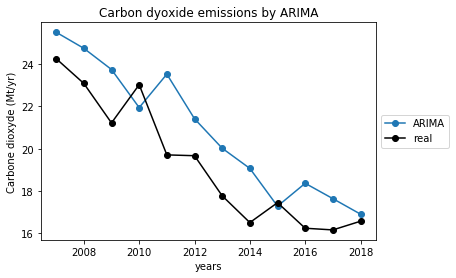

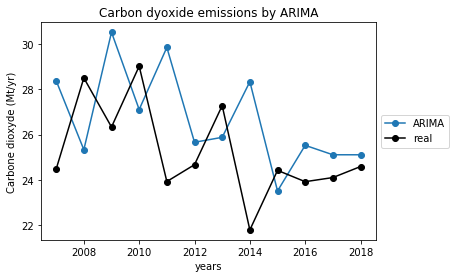

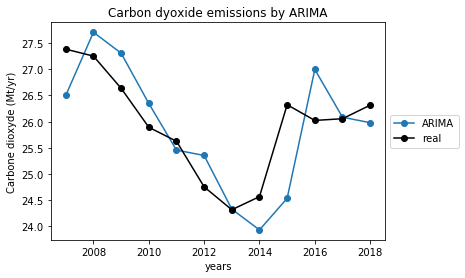

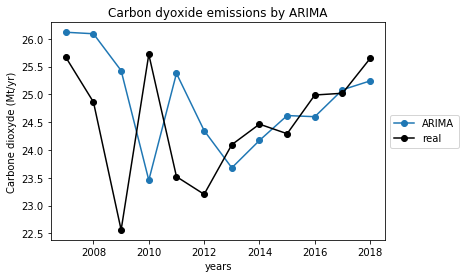

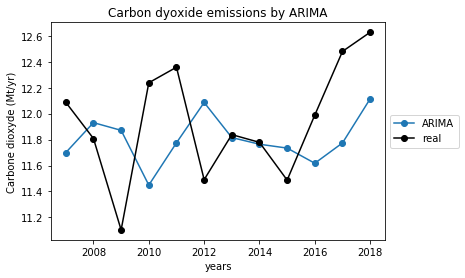

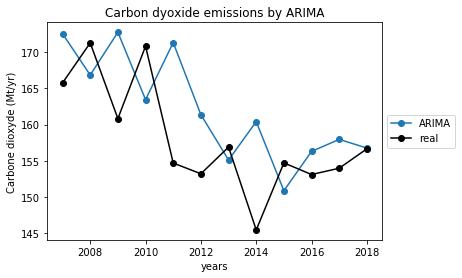

In [73]:
from statsmodels.tsa.arima_model import ARIMA

train, test = split_dataset(dataset.values, 12)

variables = [0, 1, 2, 3, 4, 5]

years = pd.Series(dataset.index.values[-12:])


list_predictions = list()
models = dict()
models['ARIMA'] = 'ARIMA'

fig = list()
for i in range(len(variables)): fig.append(go.Figure())

for var in variables:
    for name, val in models.items():
        
        eval_model = dict()
        pred = evaluate_model_autoregressive(train, test, var)
        list_predictions.append(pred)

        mae = evalutation_forecast(test[:,var], pred)
    
        figures[var] = plotly_plot_model(fig[var], pred, name)
        
        list_eval_model[var][name] = mae
    
    pyplot.plot(years, pred, marker='o', label=name)
    pyplot.plot(years, to_pd_series(test[:,var]), marker='o', label='real', color='black')
    
    pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    pyplot.title('Carbon dyoxide emissions by '+ name)
    pyplot.xlabel('years')
    pyplot.ylabel('Carbone dioxyde (Mt/yr)')
    pyplot.show()
    
    #plotly_plot_model(fig, pred, name)
    #matplotlib_plot_model(predictions, var, test, name_sector)
            

In [234]:
model_sorted(list_eval_model)

Power industry
1. lr : 1.3587070924331703
2. lars : 1.358707092433171
3. sgd : 1.3683057959406888
4. pa : 1.4131907068985836
5. huber : 1.4446913708339313
6. ranscac : 1.6384226402383455
7. ARIMA : 1.6414178143918712
8. ridge : 2.0623567815684303
9. en : 6.197874605577567
10. lasso : 6.53938799119253
11. llars : 6.618436754200076


Buildings
1. pa : 1.995929967763521
2. sgd : 2.059070819692145
3. ridge : 2.406808962700204
4. ARIMA : 2.480302275586879
5. lars : 2.5165886793370054
6. lr : 2.5344556634171838
7. huber : 2.6428260626005367
8. ranscac : 3.2084895552731716
9. en : 4.394498819073153
10. lasso : 4.400564330633393
11. llars : 4.400564330633393
12. lol : 7


Transport
1. ARIMA : 0.5292658545889631
2. huber : 0.6589214438724452
3. lr : 0.6639135294668236
4. ranscac : 0.6687487623584504
5. lars : 0.6754837817638689
6. ridge : 1.0117243713603206
7. pa : 1.2734301238545198
8. sgd : 1.289357218470557
9. en : 2.7458495836805725
10. lasso : 3.3576564835848153
11. llars : 4.5082660317299

TypeError: unhashable type: 'Figure'

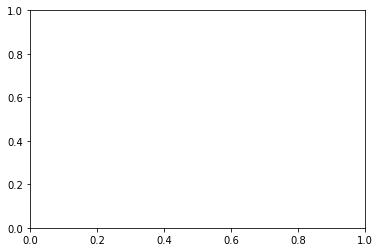

In [75]:
matplotlib_plot_model(fig, variables, test, name_sector)

### TODO ###
- comments
- read comments
- read on linear models 
- pourquoi sont-elles mals prédites ?
- pourquoi il ya de fortes variations dans les données réelles ? theoritically !
- Test the statinnarity of all variables
- ask yourself how upsampling can affect the supervided learning
- Autoregressive model (SARIMA)
- from 2019 - 2030 + graphs
- LTSM

- sliding window (done)
- forward chaining 
- transformée de fourier rapide 

- improve hyperparamter 
- conditions for using models ? Maybe 
- model evaluation => pay attention to interpretation


Questions

- Ask yourself how upsampling can affect the supervided learning ?
- Database
- Est ce que c'est de prendre le meilleur modèle par variable (secteur) ou un modèle unique 
- Is it important to test all the parameters of all linear models

Look for relation between variables

consumption of coal in function of 
- price
- population

- With the consumption of coal you can deduce -> the emissions of CO2

- Doing this for the energy mixte
- evaluate the transfer fucntion => for a certain mixte => what is going to happen in 2030.